In [2]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
# Step 1: Load dataset
df = pd.read_csv("survey.csv")
# Step 2: Drop unnecessary columns
df.drop(columns=['Timestamp', 'comments', 'state'], inplace=True)
# Step 3: Filter invalid ages
df = df[(df['Age'] >= 18) & (df['Age'] <= 100)]
# Step 4: Normalize Gender values
def clean_gender(g):
    g = str(g).lower()
    if 'male' in g:
        return 'Male'
    elif 'female' in g:
        return 'Female'
    else:
        return 'Other'
df['Gender'] = df['Gender'].apply(clean_gender)

# Step 5: Handle missing values
df['self_employed'].fillna('No', inplace=True)
df['work_interfere'].fillna("Don't know", inplace=True)

# Step 6: Encode categorical features (excluding target column)
label_encoders = {}
for col in df.select_dtypes(include='object'):
    if col != 'treatment':
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
        label_encoders[col] = le

# Step 7: Encode target column
y = df['treatment'].apply(lambda x: 1 if x == 'Yes' else 0)
X = df.drop(columns='treatment')

# Step 8: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)
# Step 9: Train Random Forest model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
# Step 10: Evaluate the model
y_pred = model.predict(X_test)
print("✅ Accuracy:", accuracy_score(y_test, y_pred))
print("\n📊 Classification Report:\n", classification_report(y_test, y_pred))


✅ Accuracy: 0.8207171314741036

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.87      0.75      0.81       124
           1       0.78      0.89      0.83       127

    accuracy                           0.82       251
   macro avg       0.83      0.82      0.82       251
weighted avg       0.83      0.82      0.82       251



C:\Users\Dipanshu Khanna\AppData\Local\Temp\ipykernel_2728\2968345917.py:28: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['self_employed'].fillna('No', inplace=True)
C:\Users\Dipanshu Khanna\AppData\Local\Temp\ipykernel_2728\2968345917.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves a

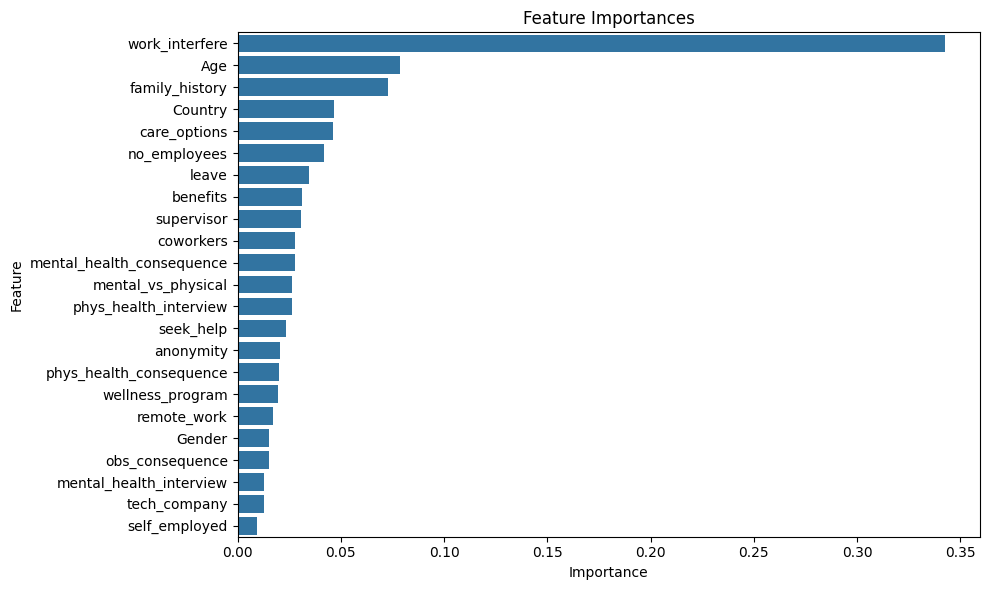

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

feature_imp = pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x=feature_imp.values, y=feature_imp.index)
plt.title("Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()


In [3]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

model = RandomForestClassifier(n_estimators=100, random_state=42)
scores = cross_val_score(model, X, y, cv=5, scoring='accuracy')

print("Cross-Validation Accuracy Scores:", scores)
print("Mean Accuracy: {:.2f}%".format(scores.mean() * 100))


Cross-Validation Accuracy Scores: [0.83665339 0.828      0.84       0.872      0.8       ]
Mean Accuracy: 83.53%


In [4]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search = GridSearchCV(
    RandomForestClassifier(random_state=42),
    param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

grid_search.fit(X, y)

print("Best Parameters:", grid_search.best_params_)
print("Best Accuracy: {:.2f}%".format(grid_search.best_score_ * 100))


Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 100}
Best Accuracy: 83.53%


In [7]:
# Select the exact columns you'll use in Streamlit
selected_features = [
    'Age', 'Gender', 'family_history', 'self_employed', 'remote_work',
    'tech_company', 'benefits', 'care_options', 'wellness_program',
    'seek_help', 'anonymity', 'leave', 'work_interfere'
]

# Subset X and retrain
X_selected = X[selected_features]

# Use best hyperparameters
best_model = RandomForestClassifier(
    n_estimators=100,
    max_depth=None,
    min_samples_split=2,
    random_state=42
)
best_model.fit(X_selected, y)

# Save model
import joblib
joblib.dump(best_model, "mental_health_model_streamlit.pkl")


['mental_health_model_streamlit.pkl']

In [8]:
import shap

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_selected)

shap.summary_plot(shap_values[1], X_selected, plot_type="bar")


NameError: name 'rf_model' is not defined

In [11]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X, y)  # Use the full feature set here

X["prediction"] = model.predict(X)
X["prediction_probability"] = model.predict_proba(X)[:, 1]
X["actual"] = y.reset_index(drop=True)

X.to_csv("mental_health_with_predictions.csv", index=False)
